# Hacks & helpers

In [ ]:
!python -m pip install ipympl
!python -m pip install seaborn
!python -m pip install vw_executor --upgrade

In [1]:
from vw_executor.vw_opts import VwOpts
from pathlib import Path

import matplotlib.pyplot as plt
import random
import pandas as pd
import json
import scipy
import seaborn as sns

from vw_executor.vw import Vw
from functools import reduce

%matplotlib widget
sns.set_theme(style="darkgrid")

def new_ax():
    _,ax = plt.subplots(dpi=100, figsize=[9,4])
    return ax    

def save_examples(examples, path):     
    with open(path, 'w') as f:
        for ex in examples:
            f.write(f'{json.dumps(ex, separators=(",", ":"))}\n')
            
def load_examples(path):
    with open(path) as f:
        for l in f:
            yield json.loads(l)

def get_simulation(folder, simulator, **kwargs):
    path = Path(folder).joinpath(f'{str(VwOpts(kwargs)).replace(" ", "-")}.json')
    if not path.exists():
        Path(folder).mkdir(parents=True, exist_ok=True)
        examples = list(simulator(**kwargs))
        save_examples(examples, path)
    else:
        examples = list(load_examples(path))
    return examples, path
    
def cb_df(examples):
    return pd.DataFrame([{
        'reward': -e['_label_cost'],
        'shared_good': e['c']['shared']['f'],
        'chosen': e['_labelIndex'],
        'prob': e['_label_probability']
    } for e in examples])    

def _collapse(*grids):
    from collections import OrderedDict
    result = reduce(lambda r, g: OrderedDict(r, **g), grids)
    separator = [len(g) for g in grids]
    return result, separator

def _split(collapsed, separator):
    result = []
    last = 0
    items = list(collapsed.items())
    for c in separator:
        result.append(dict(items[last:last + c]))
        last = last + c
    return tuple(result)

def grid_layout(elements, columns=4):
    rows = (len(elements) - 1) // columns + 1
    layout = Layout(grid_template_rows=' '.join(['auto'] * rows), grid_template_columns=' '.join(['auto'] * columns))
    return GridBox(children=elements, layout=layout)   
    
class VwPlayground:
    def __init__(self, simulation, visualization, vw_binary=None, cache_path = '.cache'):
        self.data_folder = Path(cache_path).joinpath('datasets').joinpath(str(hash(simulation.__code__)))
        self.simulation = simulation
        self.examples = None
        self.visualization = visualization
        self.last_job = None
        self.vw = Vw(cache_path, vw_binary, handlers=[])
        
    def run(self, simulator_grid, vw_grid, columns=4):
        def _run_and_plot(separator, **options):
            sim_opts, train_opts = _split(options, separator)
            self.visualization.reset()
            examples, examples_path = get_simulation(self.data_folder, self.simulation, **sim_opts)
            self.visualization.after_simulation(examples)
            self.last_job = self.vw.train(
                [examples_path], train_opts, self.visualization.vw_outputs)
            self.visualization.after_train(examples, self.last_job)

        collapsed, separator = _collapse(simulator_grid, vw_grid)
        widget = interactive(_run_and_plot, separator=fixed(separator), **collapsed)
        simulator_controls = grid_layout(widget.children[:len(simulator_grid)], columns)
        vw_controls = grid_layout(widget.children[len(simulator_grid):len(simulator_grid)+len(vw_grid)], columns)
        controls = Accordion(children=[simulator_controls, vw_controls])
        controls.set_title(0, 'Simulator args')
        controls.set_title(1, 'Vw args')
        output = widget.children[-1]
        display(VBox([controls, output]))

# Simulator

In [2]:
def my_simulation(n=10000, swap_after=5000, variance=0, bad=0):
    offset = 0
    for i in range(1, n):
        if i % swap_after == 0:
            offset = (offset + 1) % 2

        person = i % 2 
        chosen = i % 4  // 2 
        if (chosen + person + offset) % 2 == 0:
            reward =  0.7 + ((chosen + offset) % 2) * 0.1
        else:
            reward = 0.3 - ((chosen + offset + 1) % 2) * 0.1

        reward = reward + scipy.random.normal(0, variance)

        yield {
            "_label_cost": -reward,
            "_label_probability": 0.5,
            "_label_Action": chosen + 1,
            "_labelIndex": chosen,
            "a": [chosen + 1, (chosen + 1) % 2 + 1],
            "c": {'shared': {'f': str(person),
                '_multi': [
                    {'a': {'f': '0'}, 'b': {f'f{i}': random.random() for i in range(int(bad))}},
                    {'a': {'f': '1'}, 'b': {f'f{i}': random.random() for i in range(int(bad))}}]}},
            "p": [0.5, 0.5] 
        }

# Visulization

In [3]:
def visualize_env(examples, window=100, ax=None):
    ax = ax or new_ax()
    ax.set_title('Rewards')
    colors = ['green', 'red']
    styles = ['-', '-.']
    df = cb_df(examples)
    [df[(df['shared_good']==str(i)) & (df['chosen']==j)].rolling(window=window)['reward'].mean().plot(
        ax=ax, color = colors[j], style=styles[i], label=f'Person: {i}, chosen: {j}') for i in [0,1] for j in [0,1]]   
    ax.legend()
    
def visualize_learning(examples, job, window=100, ax=None):
    ax = ax or new_ax()
    ax.set_title('P(action|person)')
    colors = ['green', 'red']
    styles = ['-', '-.']
    df = pd.concat([cb_df(examples), job[0].predictions('-p').cb], axis=1)
    [(df[(df['shared_good']==str(i))][str(j)].rolling(window=window).mean() + i * 0.02).plot(
        ax=ax, color = colors[j], style=styles[i], label=f'P(chosen={j} | Person={i})') for i in [0,1] for j in [0,1]]
    ax.legend(loc='center left', bbox_to_anchor=(0.75, 0.5))

class MyVisualization:
    def __init__(self, window=100):
        fig, ax = plt.subplots(1, 2, figsize=(12,4))
        self.fig = fig
        self.ax = ax
        self.vw_outputs = ['-p']
        self.window=window
        
    def reset(self):
        self.ax[0].clear()
        self.ax[1].clear()
        
    def after_simulation(self, examples):
        visualize_env(examples, window=self.window, ax=self.ax[0]) 
        
    def after_train(self, examples, job):
        visualize_learning(examples, job, window=self.window, ax=self.ax[1])
        self.fig.canvas.draw_idle()

# Look at the data

In [4]:
examples = my_simulation(n=100, swap_after=50, variance = 0.1, bad = 1)
cb_df(examples).head()

,reward,shared_good,chosen,prob
0,0.077914,1,0,0.5
1,0.335378,0,1,0.5
2,0.859023,1,1,0.5
3,0.670708,0,0,0.5
4,0.107965,1,0,0.5


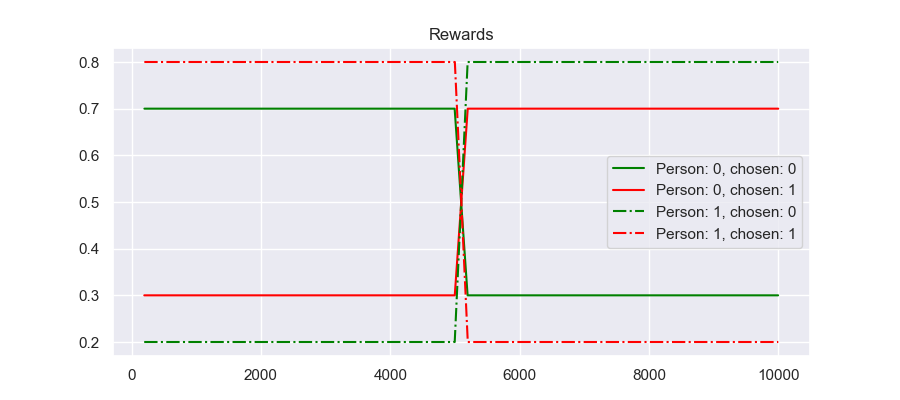

In [5]:
visualize_env(my_simulation(n=10000, swap_after=5000, variance = 0, bad = 1), window=50)

In [6]:
next(my_simulation(n=10000, swap_after=5000, variance = 0, bad = 1))

{'_label_cost': -0.19999999999999998,
 '_label_probability': 0.5,
 '_label_Action': 1,
 '_labelIndex': 0,
 'a': [1, 2],
 'c': {'shared': {'f': '1',
   '_multi': [{'a': {'f': '0'}, 'b': {'f0': 0.9164075721310359}},
    {'a': {'f': '1'}, 'b': {'f0': 0.11064345359738825}}]}},
 'p': [0.5, 0.5]}

# Interact

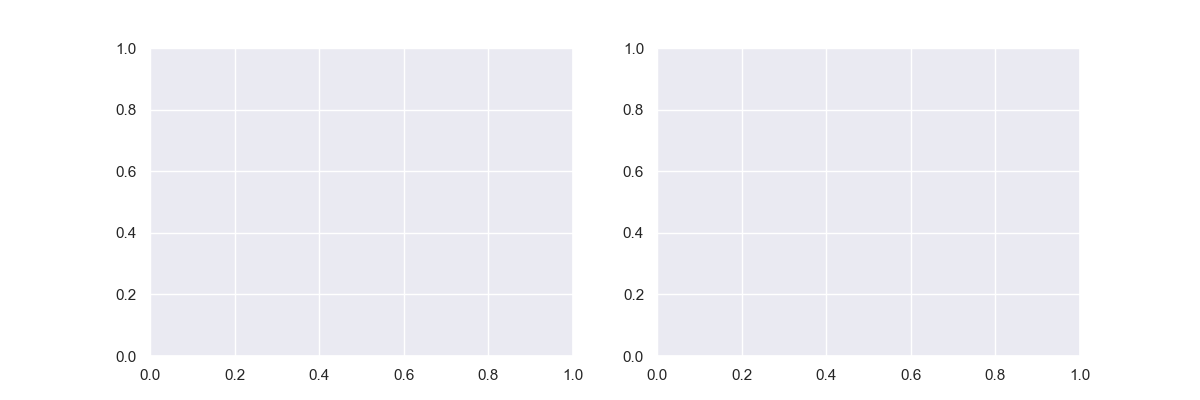

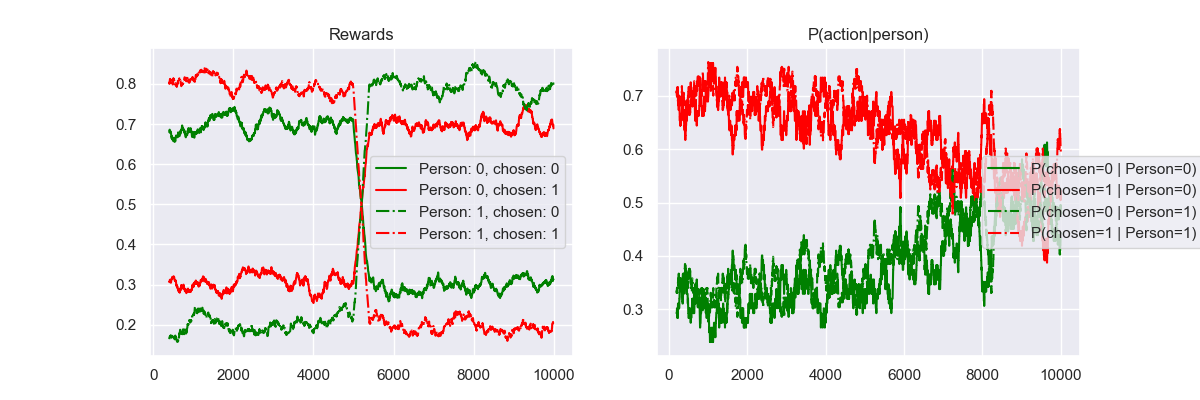

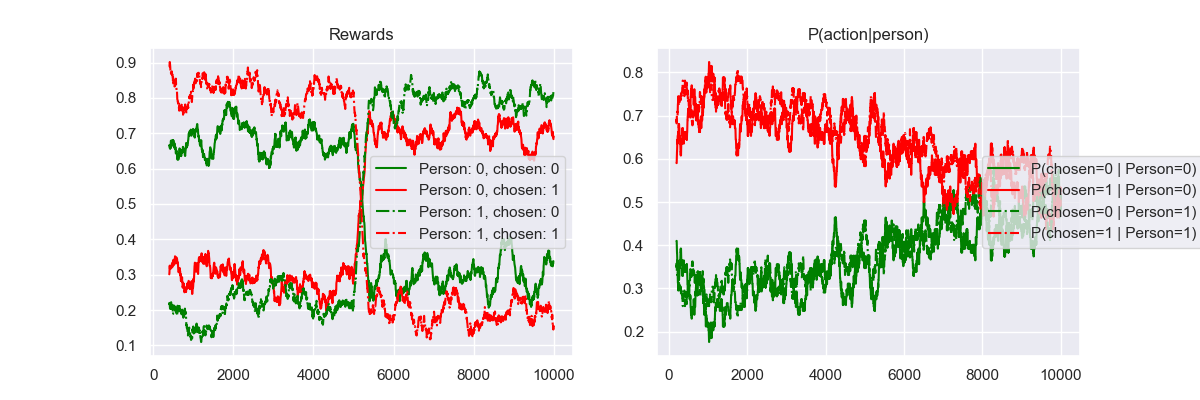

In [7]:
from ipywidgets import *

playground = VwPlayground(my_simulation, MyVisualization())
playground.run(
    simulator_grid = {
        'n': IntSlider(value=10000, min=100, max=50000),
        'swap_after': IntSlider(value=5000, min=10, max=50000),
        'variance': FloatSlider(value=0, min=0, max=1, step=0.1),
        'bad': FloatLogSlider(value=1, min=0, max=10, base=2, step=1),
    },
    vw_grid = {
        '#base': fixed('--cb_explore_adf --dsjson --power_t 0'),
        '--learning_rate': FloatLogSlider(value=2**(-20), min=-20, max=10, base=2, step=1),
        '--cb_type': ['ips', 'mtr'],
        '--l1': FloatLogSlider(value=2**(-20), min=-20, max=10, base=2, step=1),
        '#interactions': ['', '-q sa', '-q ::'],
        '#exploration': ['--epsilon 0.1', '--squarecb', '--cover 5', '--synthcover']
    },
    columns=3
)

In [ ]:
print('Last command line')
print(playground.last_job[0].args)

In [ ]:
playground.last_job[0].stdout.raw

In [4]:
import os
from random import random, randint
import mlflow
from mlflow import log_metric, log_param, log_artifacts

In [ ]:
mlflow.create_experiment

In [13]:
mlflow.end_run()

In [18]:
mlflow.get_run("test_run_1")

RestException: RESOURCE_DOES_NOT_EXIST: Run 'test_run_1' not found

In [26]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
#mlflow.create_experiment("my-experiment-1")
mlflow.set_experiment("my-experiment-1")
with mlflow.start_run():
    mlflow.log_params({'a': 1, 'b': 2})
    mlflow.log_metric('Metric', 1)
    mlflow.log_metric('Metric', 2)
    mlflow.log_metric('Metric', 3)    
#log_param("param1", randint(0, 100))

In [27]:
exp = mlflow.start_run()

In [ ]:
mlflow.log_figure()

In [30]:
exp.info.run_id

'8cd72dfe4ebc4c6aa33108bd93334d56'

In [8]:
from  mlflow.tracking import MlflowClient
client = MlflowClient(tracking_uri = '127.0.0.1:5000', registry_uri='file:registry')

UnsupportedModelRegistryStoreURIException:  Model registry functionality is unavailable; got unsupported URI '127.0.0.1:5000' for model registry data storage. Supported URI schemes are: ['', 'file', 'databricks', 'http', 'https', 'postgresql', 'mysql', 'sqlite', 'mssql']. See https://www.mlflow.org/docs/latest/tracking.html#storage for how to run an MLflow server against one of the supported backend storage locations.

In [2]:
client.list_experiments()

[<Experiment: artifact_location='file:///Users/alextaim/src/github/ataymano/data-science/from_mwt_ds/DataScience/mlruns/0', experiment_id='0', lifecycle_stage='active', name='Default', tags={}>]

In [5]:
exp_id = client.create_experiment("blabla_3")

In [38]:
run = client.create_run(experiment_id=exp_id)

In [42]:
run.info.run_id

'13caab2fd96147c4a8a06a80bb502350'

In [43]:
client.log_metric(run.info.run_id, "metric", 2)

In [ ]:
client.log_param()

mlflow.